In [17]:
# apt-get install libhdf5-dev
#! pip install --user --upgrade pip setuptools wheel
! pip install --user versioned-hdf5
! pip install --user tqdm --upgrade
! pip install torchsummary
! pip install --user dill --upgrade
#! pip install --user h5py

Requirement already up-to-date: tqdm in /tmp/home_dir/.local/lib/python3.8/site-packages (4.62.3)
Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: dill in /tmp/home_dir/.local/lib/python3.8/site-packages (0.3.4)


In [18]:
# Import some general modules
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [19]:
# Select which GPU to use (if available)
gpu = 0
if torch.cuda.is_available():
    torch.cuda.device(gpu)
    print("Using GPU %d" % gpu)
else:
    gpu = None
    print("Using CPU only")

Using GPU 0


# Model topology

In [3]:
from torch import nn
import brevitas.nn as qnn
from brevitas.quant import IntBias
from brevitas.inject.enum import ScalingImplType
from brevitas.inject.defaults import Int8ActPerTensorFloatMinMaxInit

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

model_name = "VGG10exp_2d_w4a4_v2"

path_trained = "models/" + model_name + "_trained.pth"
export_model_filename = "models/" + model_name + "_export.onnx"
ready_model_filename = "models/" + model_name + "_ready.onnx"

class Model(nn.Module):
    def __init__(self, trial=None):
        super(Model, self).__init__()

        # Adjustable hyperparameters
        input_bits = 8
        a_bits = 4
        w_bits = 4
        filters_conv = 128
        filters_dense = 128
        input_quant_range = 2

        class InputQuantizer(Int8ActPerTensorFloatMinMaxInit):
            min_val = -input_quant_range
            max_val = input_quant_range
            scaling_impl_type = ScalingImplType.CONST
            bit_width = input_bits

        self.core = nn.Sequential(
            qnn.QuantHardTanh(act_quant=InputQuantizer, return_quant_tensor=True), # input quantization
            
            qnn.QuantConv2d(2, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
            nn.BatchNorm2d(filters_conv),
            qnn.QuantReLU(bit_width=a_bits, return_quant_tensor=True),
            #nn.MaxPool2d(2),

            qnn.QuantConv2d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
            nn.BatchNorm2d(filters_conv),
            qnn.QuantReLU(bit_width=a_bits, return_quant_tensor=True),
            nn.MaxPool2d(2),

            qnn.QuantConv2d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
            nn.BatchNorm2d(filters_conv),
            qnn.QuantReLU(bit_width=a_bits, return_quant_tensor=True),
            #nn.MaxPool2d(2),

            qnn.QuantConv2d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits,bias=False),
            nn.BatchNorm2d(filters_conv),
            qnn.QuantReLU(bit_width=a_bits, return_quant_tensor=True),
            nn.MaxPool2d(2),
            
            nn.Flatten(),

            qnn.QuantLinear(int(filters_conv*8*8), filters_dense, weight_bit_width=w_bits, bias=False),
            nn.BatchNorm1d(filters_dense),
            qnn.QuantReLU(bit_width=a_bits, return_quant_tensor=True),

            qnn.QuantLinear(filters_dense, 24, weight_bit_width=w_bits, bias=True, bias_quant=IntBias),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        #x = x.reshape(-1,2,int(1024/interleave),int(interleave))
        #x = x.permute(0,1,3,2).contiguous()
        x = x.reshape(-1,2,32,32)
        x = self.core(x)
        return x
    
model = Model()

In [ ]:
#NON-Brevitas model for TensorRT/AIE
from torch import nn
from torchsummary import summary
# Setting seeds for reproducibility
torch.manual_seed(123456)
np.random.seed(123456)

model_name = "VGG10_TensorRT"

path_trained = "models/" + model_name + "_trained.pth"
export_model_filename = "models/" + model_name + "_export.onnx"
ready_model_filename = "models/" + model_name + "_ready.onnx"

filters_conv = 64
filters_dense = 128
        
model = nn.Sequential(
    nn.Conv1d(2, filters_conv, 3, padding=1, bias=False),
    nn.BatchNorm1d(filters_conv),
    nn.ReLU(),
    nn.MaxPool1d(2),

    nn.Conv1d(filters_conv, filters_conv, 3, padding=1, bias=False),
    nn.BatchNorm1d(filters_conv),
    nn.ReLU(),
    nn.MaxPool1d(2),

    nn.Conv1d(filters_conv, filters_conv, 3, padding=1, bias=False),
    nn.BatchNorm1d(filters_conv),
    nn.ReLU(),
    nn.MaxPool1d(2),

    nn.Conv1d(filters_conv, filters_conv, 3, padding=1, bias=False),
    nn.BatchNorm1d(filters_conv),
    nn.ReLU(),
    nn.MaxPool1d(2),

    nn.Conv1d(filters_conv, filters_conv, 3, padding=1, bias=False),
    nn.BatchNorm1d(filters_conv),
    nn.ReLU(),
    nn.MaxPool1d(2),

    nn.Conv1d(filters_conv, filters_conv, 3, padding=1, bias=False),
    nn.BatchNorm1d(filters_conv),
    nn.ReLU(),
    nn.MaxPool1d(2),

    nn.Conv1d(filters_conv, filters_conv, 3, padding=1, bias=False),
    nn.BatchNorm1d(filters_conv),
    nn.ReLU(),
    nn.MaxPool1d(2),

    nn.Flatten(),

    nn.Linear(filters_conv*8, filters_dense, bias=False),
    nn.BatchNorm1d(filters_dense),
    nn.ReLU(),

    nn.Linear(filters_dense, filters_dense, bias=False),
    nn.BatchNorm1d(filters_dense),
    nn.ReLU(),

    nn.Linear(filters_dense, 24, bias=True),
    nn.LogSoftmax(dim=1)
)


x = torch.randn(1, 2, 1024)
summary(model, (2,1024))

In [10]:
#NON-Brevitas model for AIE (no linear layer)
from torch import nn

# Setting seeds for reproducibility
torch.manual_seed(123456)
np.random.seed(123456)

model_name = "VGG10_TensorRT"

path_trained = "models/" + model_name + "_trained.pth"
export_model_filename = "models/" + model_name + "_export.onnx"
ready_model_filename = "models/" + model_name + "_ready.onnx"

filters_conv = 64
filters_dense = 128
        
model = nn.Sequential(
    nn.Conv1d(2, filters_conv, 3, padding=1, bias=False),
    nn.BatchNorm1d(filters_conv),
    nn.ReLU(),
    nn.MaxPool1d(2),

    nn.Conv1d(filters_conv, filters_conv, 3, padding=1, bias=False),
    nn.BatchNorm1d(filters_conv),
    nn.ReLU(),
    nn.MaxPool1d(2),

    nn.Conv1d(filters_conv, filters_conv, 3, padding=1, bias=False),
    nn.BatchNorm1d(filters_conv),
    nn.ReLU(),
    nn.MaxPool1d(2),

    nn.Conv1d(filters_conv, filters_conv, 3, padding=1, bias=False),
    nn.BatchNorm1d(filters_conv),
    nn.ReLU(),
    nn.MaxPool1d(2),

    nn.Conv1d(filters_conv, filters_conv, 3, padding=1, bias=False),
    nn.BatchNorm1d(filters_conv),
    nn.ReLU(),
    nn.MaxPool1d(2),

    nn.Conv1d(filters_conv, filters_conv, 3, padding=1, bias=False),
    nn.BatchNorm1d(filters_conv),
    nn.ReLU(),
    nn.MaxPool1d(2),

    nn.Conv1d(filters_conv, filters_conv, 3, padding=1, bias=False),
    nn.BatchNorm1d(filters_conv),
    nn.ReLU(),
    nn.MaxPool1d(2),

    # flatten into C dimension, L=1
    nn.Flatten(),
    nn.Unflatten(1, (filters_conv*8, 1)),

    nn.Conv1d(filters_conv*8, filters_dense, 1, bias=False),
    nn.BatchNorm1d(filters_dense),
    nn.ReLU(),

    nn.Conv1d(filters_dense, filters_dense, 1, bias=False),
    nn.BatchNorm1d(filters_dense),
    nn.ReLU(),

    nn.Conv1d(filters_dense, 24, 1, bias=True),
    nn.Flatten(),
    nn.LogSoftmax(dim=1)
)

summary(model, (2,1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 1024]             384
       BatchNorm1d-2             [-1, 64, 1024]             128
              ReLU-3             [-1, 64, 1024]               0
         MaxPool1d-4              [-1, 64, 512]               0
            Conv1d-5              [-1, 64, 512]          12,288
       BatchNorm1d-6              [-1, 64, 512]             128
              ReLU-7              [-1, 64, 512]               0
         MaxPool1d-8              [-1, 64, 256]               0
            Conv1d-9              [-1, 64, 256]          12,288
      BatchNorm1d-10              [-1, 64, 256]             128
             ReLU-11              [-1, 64, 256]               0
        MaxPool1d-12              [-1, 64, 128]               0
           Conv1d-13              [-1, 64, 128]          12,288
      BatchNorm1d-14              [-1, 

In [20]:
# TRAINED MODEL FROM DETERMINED.AI
from torch import nn
import brevitas.nn as qnn
from brevitas.quant import IntBias
from brevitas.inject.enum import ScalingImplType
from brevitas.inject.defaults import Int8ActPerTensorFloatMinMaxInit

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

model_name = "18_VGG10_w3a3_v2"

path_trained = "models/" + model_name + "_trained.pth"
export_model_filename = "models/" + model_name + "_export.onnx"
ready_model_filename = "models/" + model_name + "_ready.onnx"


class Model(nn.Module):
    def __init__(self, trial=None):
        super(Model, self).__init__()

        dropout_conv = 0
        dropout_dense = 0
        input_bits = 8
        a_bits = 3
        w_bits = 3
        a_bits_first = 3
        w_bits_first = 3
        filters_conv = 64
        filters_dense = 128
        channelwise_w_scaling = True
        remove_dense_layer = False
        input_quant_range = 2.0
        
        class InputQuantizer(Int8ActPerTensorFloatMinMaxInit):
            min_val = -input_quant_range
            max_val = input_quant_range
            scaling_impl_type = ScalingImplType.CONST
            bit_width = input_bits

        self.core = nn.Sequential(
            qnn.QuantHardTanh(act_quant=InputQuantizer, return_quant_tensor=True), # input quantization
            qnn.QuantConv1d(2, filters_conv, 3, padding=1, weight_bit_width=w_bits_first, weight_scaling_per_output_channel=channelwise_w_scaling, bias=False), #1x3 kernel, pad by 1 on each side
            nn.BatchNorm1d(filters_conv),
            #qnn.QuantReLU(bit_width=a_bits_first, return_quant_tensor=True),
            qnn.QuantHardTanh(bit_width=a_bits_first, max_val=1.0, min_val=-1.0, return_quant_tensor=True),
            nn.Dropout2d(dropout_conv),

            qnn.QuantMaxPool1d(2),

            qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, weight_scaling_per_output_channel=channelwise_w_scaling, bias=False), #1x3 kernel, pad by 1 on each side
            nn.BatchNorm1d(filters_conv),
            #qnn.QuantReLU(bit_width=a_bits, return_quant_tensor=True),
            qnn.QuantHardTanh(bit_width=a_bits, max_val=1.0, min_val=-1.0, return_quant_tensor=True),
            nn.Dropout2d(dropout_conv),

            qnn.QuantMaxPool1d(2),

            qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, weight_scaling_per_output_channel=channelwise_w_scaling, bias=False), #1x3 kernel, pad by 1 on each side
            nn.BatchNorm1d(filters_conv),
            qnn.QuantHardTanh(bit_width=a_bits, max_val=1.0, min_val=-1.0, return_quant_tensor=True),
            nn.Dropout2d(dropout_conv),

            qnn.QuantMaxPool1d(2),

            qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, weight_scaling_per_output_channel=channelwise_w_scaling, bias=False), #1x3 kernel, pad by 1 on each side
            nn.BatchNorm1d(filters_conv),
            qnn.QuantHardTanh(bit_width=a_bits, max_val=1.0, min_val=-1.0, return_quant_tensor=True),
            nn.Dropout2d(dropout_conv),

            qnn.QuantMaxPool1d(2),

            qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, weight_scaling_per_output_channel=channelwise_w_scaling, bias=False), #1x3 kernel, pad by 1 on each side
            nn.BatchNorm1d(filters_conv),
            qnn.QuantHardTanh(bit_width=a_bits, max_val=1.0, min_val=-1.0, return_quant_tensor=True),
            nn.Dropout2d(dropout_conv),

            qnn.QuantMaxPool1d(2),

            qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, weight_scaling_per_output_channel=channelwise_w_scaling, bias=False), #1x3 kernel, pad by 1 on each side
            nn.BatchNorm1d(filters_conv),
            qnn.QuantHardTanh(bit_width=a_bits, max_val=1.0, min_val=-1.0, return_quant_tensor=True),
            nn.Dropout2d(dropout_conv),

            qnn.QuantMaxPool1d(2),

            qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, weight_scaling_per_output_channel=channelwise_w_scaling, bias=False), #1x3 kernel, pad by 1 on each side
            nn.BatchNorm1d(filters_conv),
            qnn.QuantHardTanh(bit_width=a_bits, max_val=1.0, min_val=-1.0, return_quant_tensor=True),
            nn.Dropout2d(dropout_conv),

            qnn.QuantMaxPool1d(2),
            nn.Flatten(),

            qnn.QuantLinear(filters_conv*8, filters_dense, bias=False, weight_bit_width=w_bits, weight_scaling_per_output_channel=channelwise_w_scaling),
            nn.BatchNorm1d(filters_dense),
            qnn.QuantHardTanh(bit_width=a_bits, max_val=1.0, min_val=-1.0, return_quant_tensor=True),
            nn.Dropout(dropout_dense),
        )

        if remove_dense_layer:
            self.final_layers = nn.Sequential(
                qnn.QuantLinear(filters_dense, 24, bias=True, weight_bit_width=w_bits, weight_scaling_per_output_channel=False, bias_quant=IntBias),
                nn.LogSoftmax(dim=1)

            )
        else:
            self.final_layers = nn.Sequential(
                qnn.QuantLinear(filters_dense, filters_dense, bias=False, weight_bit_width=w_bits, weight_scaling_per_output_channel=channelwise_w_scaling),
                nn.BatchNorm1d(filters_dense),
                qnn.QuantHardTanh(bit_width=a_bits, max_val=1.0, min_val=-1.0, return_quant_tensor=True),
                nn.Dropout(dropout_dense),

                qnn.QuantLinear(filters_dense, 24, bias=True, weight_bit_width=w_bits, weight_scaling_per_output_channel=False, bias_quant=IntBias),
                nn.LogSoftmax(dim=1)

            )

    def forward(self, x):
        #x = x.permute(0,2,1).contiguous() #convert to NCL (-1,2,1024)
        x = self.core(x)
        x = self.final_layers(x)
        return x
    
model = Model()

# Data loader

In [5]:
# Check if dataset is present
import os.path
dataset_path = "/home/felixj/WD/datasets/RadioML/2018/GOLD_XYZ_OSC.0001_1024.hdf5"
os.path.isfile(dataset_path)

True

In [6]:
# Prepare data loader
from torch.utils.data import Dataset, DataLoader
import h5py

class radioml_18_dataset(Dataset):
    def __init__(self, dataset_path):
        super(radioml_18_dataset, self).__init__()
        h5_file = h5py.File(dataset_path,'r')
        self.data = h5_file['X']
        self.mod = np.argmax(h5_file['Y'], axis=1) # comes in one-hot encoding
        self.snr = h5_file['Z'][:,0]
        self.len = self.data.shape[0]

        self.mod_classes = ['OOK','4ASK','8ASK','BPSK','QPSK','8PSK','16PSK','32PSK',
        '16APSK','32APSK','64APSK','128APSK','16QAM','32QAM','64QAM','128QAM','256QAM',
        'AM-SSB-WC','AM-SSB-SC','AM-DSB-WC','AM-DSB-SC','FM','GMSK','OQPSK']
        self.snr_classes = np.arange(-20., 32., 2) # -20dB to 30dB

        # do not touch this seed to ensure the prescribed train/test split!
        np.random.seed(2018)
        train_indices = []
        test_indices = []
        for mod in range(0, 24): # all modulations (0 to 23)
            for snr_idx in range(0, 26): # all SNRs (0 to 25 = -20dB to +30dB)
                # 'X' holds frames strictly ordered by modulation and SNR
                start_idx = 26*4096*mod + 4096*snr_idx
                indices_subclass = list(range(start_idx, start_idx+4096))
                
                # 90%/10% training/test split, applied evenly for each mod-SNR pair
                split = int(np.ceil(0.1 * 4096)) 
                np.random.shuffle(indices_subclass)
                train_indices_subclass = indices_subclass[split:]
                test_indices_subclass = indices_subclass[:split]
                
                # train on >= -6 dB
                if snr_idx >= 7:
                # short training for test
                #if snr_idx >=25:
                    train_indices.extend(train_indices_subclass)
                test_indices.extend(test_indices_subclass)
                
        self.train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        self.test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    def __getitem__(self, idx):
        # transpose frame into Pytorch channels-first format (NCL = -1,2,1024)
        return self.data[idx].transpose(), self.mod[idx], self.snr[idx]

    def __len__(self):
        return self.len

dataset = radioml_18_dataset(dataset_path)

# Training

In [7]:
from sklearn.metrics import accuracy_score

def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    

    for (inputs, target, snr) in tqdm(train_loader, desc="Batches", leave=False):   
        if gpu is not None:
            inputs = inputs.cuda()
            target = target.cuda()
                
        # forward pass
        output = model(inputs)
        loss = criterion(output, target)
        
        # backward pass + run optimizer to update weights
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.cpu().detach().numpy())
           
    return losses

def test(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for (inputs, target, snr) in test_loader:
            if gpu is not None:
                inputs = inputs.cuda()
                target = target.cuda()
            output = model(inputs)
            pred = output.argmax(dim=1, keepdim=True)
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [8]:
batch_size = 128
num_epochs = 1

data_loader_train = DataLoader(dataset, batch_size=batch_size, sampler=dataset.train_sampler)
data_loader_test = DataLoader(dataset, batch_size=batch_size, sampler=dataset.test_sampler)

if gpu is not None:
    model = model.cuda()

# loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
if gpu is not None:
    criterion = criterion.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)

running_loss = []
running_test_acc = []

for epoch in tqdm(range(num_epochs), desc="Epochs"):
        loss_epoch = train(model, data_loader_train, optimizer, criterion)
        test_acc = test(model, data_loader_test)
        print("Epoch %d: Training loss = %f, test accuracy = %f" % (epoch, np.mean(loss_epoch), test_acc))
        running_loss.append(loss_epoch)
        running_test_acc.append(test_acc)
        lr_scheduler.step()

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/13132 [00:00<?, ?it/s]

Epoch 0: Training loss = 1.010981, test accuracy = 0.374945


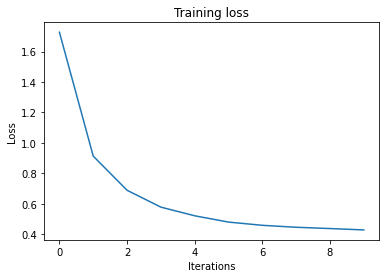

In [25]:
# Plot training loss over epochs
loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

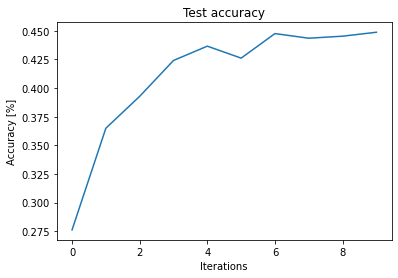

In [26]:
# Plot test accuracy over epochs
acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")

In [34]:
# Save the trained parameters to disk
torch.save(model.state_dict(), path_trained)

# Load trained model

In [21]:
# Load trained parameters
savefile = "models/18_VGG10_w3a3_v2/state_dict.pth"
saved_state = torch.load(savefile, map_location=torch.device("cpu"))
#model.load_state_dict(saved_state)
model.load_state_dict(saved_state['models_state_dict'][0])
if gpu is not None:
    model = model.cuda()

# Export to FINN

In [22]:
model.eval()
input_shape = (1, 2, 1024)

# old export style:
from brevitas.export import FINNManager
FINNManager.export(model.cpu(), input_shape=input_shape, export_path=export_model_filename)

# create a QuantTensor instance to mark input as INT8 during export
#import brevitas.onnx as bo
#from brevitas.quant_tensor import QuantTensor
#input_a = np.random.randint(0, 8, size=input_shape).astype(np.float32)
#scale = 1.0
#input_t = torch.from_numpy(input_a * scale)
#input_qt = QuantTensor(input_t, scale=torch.tensor(scale), bit_width=torch.tensor(8.0), signed=True)
#bo.export_finn_onnx(VGG10, export_path=export_model_filename, input_t=input_qt)

print("Model saved to %s" % export_model_filename)

Model saved to models/18_VGG10_w3a3_v2_export.onnx


In [13]:
from finn.util.visualization import showInNetron
showInNetron(export_model_filename)

Stopping http://0.0.0.0:8081
Serving 'models/VGG10exp_2d_w4a4_v2_export.onnx' at http://0.0.0.0:8081


# Network surgery

In [23]:
import onnx
from onnx import TensorProto, helper
from finn.core.modelwrapper import ModelWrapper
from finn.core.datatype import DataType
from finn.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames
from finn.transformation.infer_shapes import InferShapes
from finn.transformation.infer_datatypes import InferDataTypes
from finn.transformation.insert_topk import InsertTopK

finn_model = ModelWrapper(export_model_filename)

# tidy up
finn_model = finn_model.transform(InferShapes())
finn_model = finn_model.transform(InferDataTypes())
finn_model = finn_model.transform(GiveUniqueNodeNames())
finn_model = finn_model.transform(GiveReadableTensorNames())
finn_model.cleanup()

# remove redundant value_info for primary input/output
# othwerwise, newer FINN versions will not accept the model
if finn_model.graph.input[0] in finn_model.graph.value_info:
    finn_model.graph.value_info.remove(finn_model.graph.input[0])
if finn_model.graph.output[0] in finn_model.graph.value_info:
    finn_model.graph.value_info.remove(finn_model.graph.output[0])

# extract input quantization thresholds for sw-based quantization
input_mt_node = finn_model.get_nodes_by_op_type("MultiThreshold")[0]
input_mt_thresholds = finn_model.get_initializer(input_mt_node.input[1])
print("input quant thresholds")
print(input_mt_thresholds)

# preprocessing: remove input reshape/quantization from graph
new_input_node = finn_model.get_nodes_by_op_type("Mul")[0]
new_input_tensor = finn_model.get_tensor_valueinfo(new_input_node.input[0])
old_input_tensor = finn_model.graph.input[0]
finn_model.graph.input.remove(old_input_tensor)
finn_model.graph.input.append(new_input_tensor)
new_input_index = finn_model.get_node_index(new_input_node)
del finn_model.graph.node[0:new_input_index]

# postprocessing: remove final softmax node from training
softmax_node = finn_model.graph.node[-1]
softmax_in_tensor = finn_model.get_tensor_valueinfo(softmax_node.input[0])
softmax_out_tensor = finn_model.get_tensor_valueinfo(softmax_node.output[0])
finn_model.graph.output.remove(softmax_out_tensor)
finn_model.graph.output.append(softmax_in_tensor)
finn_model.graph.node.remove(softmax_node)

# remove redundant value_info for primary input/output
# othwerwise, newer FINN versions will not accept the model
if finn_model.graph.input[0] in finn_model.graph.value_info:
    finn_model.graph.value_info.remove(finn_model.graph.input[0])
if finn_model.graph.output[0] in finn_model.graph.value_info:
    finn_model.graph.value_info.remove(finn_model.graph.output[0])

# insert topK node in its place
finn_model = finn_model.transform(InsertTopK(k=1))

# manually set input datatype (not done by brevitas yet)
finnonnx_in_tensor_name = finn_model.graph.input[0].name
finnonnx_model_in_shape = finn_model.get_tensor_shape(finnonnx_in_tensor_name)
finn_model.set_tensor_datatype(finnonnx_in_tensor_name, DataType["INT8"])
print("Input tensor name: %s" % finnonnx_in_tensor_name)
print("Input tensor shape: %s" % str(finnonnx_model_in_shape))
print("Input tensor datatype: %s" % str(finn_model.get_tensor_datatype(finnonnx_in_tensor_name)))

finn_model.save(ready_model_filename)

input quant thresholds
[[-1.9921875 -1.9765625 -1.9609375 -1.9453125 -1.9296875 -1.9140625
  -1.8984375 -1.8828125 -1.8671875 -1.8515625 -1.8359375 -1.8203125
  -1.8046875 -1.7890625 -1.7734375 -1.7578125 -1.7421875 -1.7265625
  -1.7109375 -1.6953125 -1.6796875 -1.6640625 -1.6484375 -1.6328125
  -1.6171875 -1.6015625 -1.5859375 -1.5703125 -1.5546875 -1.5390625
  -1.5234375 -1.5078125 -1.4921875 -1.4765625 -1.4609375 -1.4453125
  -1.4296875 -1.4140625 -1.3984375 -1.3828125 -1.3671875 -1.3515625
  -1.3359375 -1.3203125 -1.3046875 -1.2890625 -1.2734375 -1.2578125
  -1.2421875 -1.2265625 -1.2109375 -1.1953125 -1.1796875 -1.1640625
  -1.1484375 -1.1328125 -1.1171875 -1.1015625 -1.0859375 -1.0703125
  -1.0546875 -1.0390625 -1.0234375 -1.0078125 -0.9921875 -0.9765625
  -0.9609375 -0.9453125 -0.9296875 -0.9140625 -0.8984375 -0.8828125
  -0.8671875 -0.8515625 -0.8359375 -0.8203125 -0.8046875 -0.7890625
  -0.7734375 -0.7578125 -0.7421875 -0.7265625 -0.7109375 -0.6953125
  -0.6796875 -0.6640625 -

In [23]:
from finn.util.visualization import showInNetron
showInNetron(ready_model_filename)

Serving 'models/18_VGG10_w4a4w4a3_v2_ready.onnx' at http://0.0.0.0:8081


# FINN build

In [3]:
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
from finn.core.modelwrapper import ModelWrapper
from finn.transformation.change_3d_tensors_to_4d import Change3DTo4DTensors

ready_model_filename = "VGG10_ready.onnx"

def step_convert_1d_conv(model: ModelWrapper, cfg: build_cfg):
    model = model.transform(Change3DTo4DTensors())
    return model

steps = [
        "step_tidy_up",
        step_convert_1d_conv,
        "step_streamline",
        "step_convert_to_hls",
        "step_create_dataflow_partition",
        "step_target_fps_parallelization",
        "step_apply_folding_config",
        "step_generate_estimate_reports",
        "step_hls_codegen",
        "step_hls_ipgen",
        "step_set_fifo_depths",
        "step_create_stitched_ip",
        "step_measure_rtlsim_performance",
        "step_out_of_context_synthesis",
        "step_synthesize_bitfile",
        "step_make_pynq_driver",
        "step_deployment_package",
    ]

cfg = build_cfg.DataflowBuildConfig(
        steps=steps,
        output_dir="build_end2end_ZCU102",
        board="ZCU102",
        synth_clk_period_ns=5.0,
        folding_config_file="folding_config/ZCU102_folding_config.json",
        #target_fps=1000000,
        #mvau_wwidth_max=128,
        auto_fifo_depths=True,
        shell_flow_type=build_cfg.ShellFlowType.VIVADO_ZYNQ,
        vitis_platform=None,
        # enable extra performance optimizations (physopt)
        vitis_opt_strategy=build_cfg.VitisOptStrategyCfg.PERFORMANCE_BEST,
        generate_outputs=[
            build_cfg.DataflowOutputType.PYNQ_DRIVER,
            build_cfg.DataflowOutputType.ESTIMATE_REPORTS,
            build_cfg.DataflowOutputType.BITFILE,
            build_cfg.DataflowOutputType.DEPLOYMENT_PACKAGE,
        ],
    )

#build.build_dataflow_cfg(ready_model_filename, cfg)

Building dataflow accelerator from VGG10_ready.onnx
Intermediate outputs will be generated in /home/felixj/tmp_finn
Final outputs will be generated in build_end2end_ZCU102
Build log is at build_end2end_ZCU102/build_dataflow.log
Running step: step_tidy_up [1/17]
Running step: step_convert_1d_conv [2/17]
Running step: step_streamline [3/17]
Running step: step_convert_to_hls [4/17]
Running step: step_create_dataflow_partition [5/17]
Running step: step_target_fps_parallelization [6/17]
Running step: step_apply_folding_config [7/17]
Running step: step_generate_estimate_reports [8/17]
Running step: step_hls_codegen [9/17]
Running step: step_hls_ipgen [10/17]
Running step: step_set_fifo_depths [11/17]
Running step: step_create_stitched_ip [12/17]
Running step: step_measure_rtlsim_performance [13/17]
Running step: step_out_of_context_synthesis [14/17]
Running step: step_synthesize_bitfile [15/17]
Running step: step_make_pynq_driver [16/17]
Running step: step_deployment_package [17/17]
Complete

0

In [10]:
# Export to regular ONNX for TensorRT
import torch.onnx

batch_sizes = [1, 4, 8, 32, 64, 128, 1024, 4096]
for batch_size in batch_sizes:
    export_model_filename = "models/" + model_name + "_" + str(batch_size) + "_export.onnx"
    dummy_input=torch.randn(batch_size, 2, 1024)
    torch.onnx.export(model.cpu(), dummy_input, export_model_filename, verbose=False)